In [1]:
#----------------------------------------------
# Stefano Piacentini - 28/03/2020
#----------------------------------------------

library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [2]:
rate_sim = function(x,
                    A = 0.,
                    T = 1.,
                    phi = 0. * pi,
                    B = 0.01,
                    SAW = 0) {
    ret <- A * cos(2 * pi * x / T + phi) - SAW * (B*T)/2. + SAW *B * ((x) %% (T))
    return(ret)
}

In [3]:
# Setting "true values" for simulated data
par_A        <- 0.02 
par_B        <- 0.02
par_Bosaw    <- 0.04
par_phi      <- 0.5 * pi
par_T        <- 1

# Setting errors for simulated data
err   <- 0.01

# Setting number of points of the histogram
N     <- 50

# Setting parameters for unif. priors
B_0       <- 0.0
max_A     <- 0.05
width_B   <- 0.1
max_phi   <- 2*pi

# For our pourpose for the pseudodata
# analysis we can set T to be equal to 1

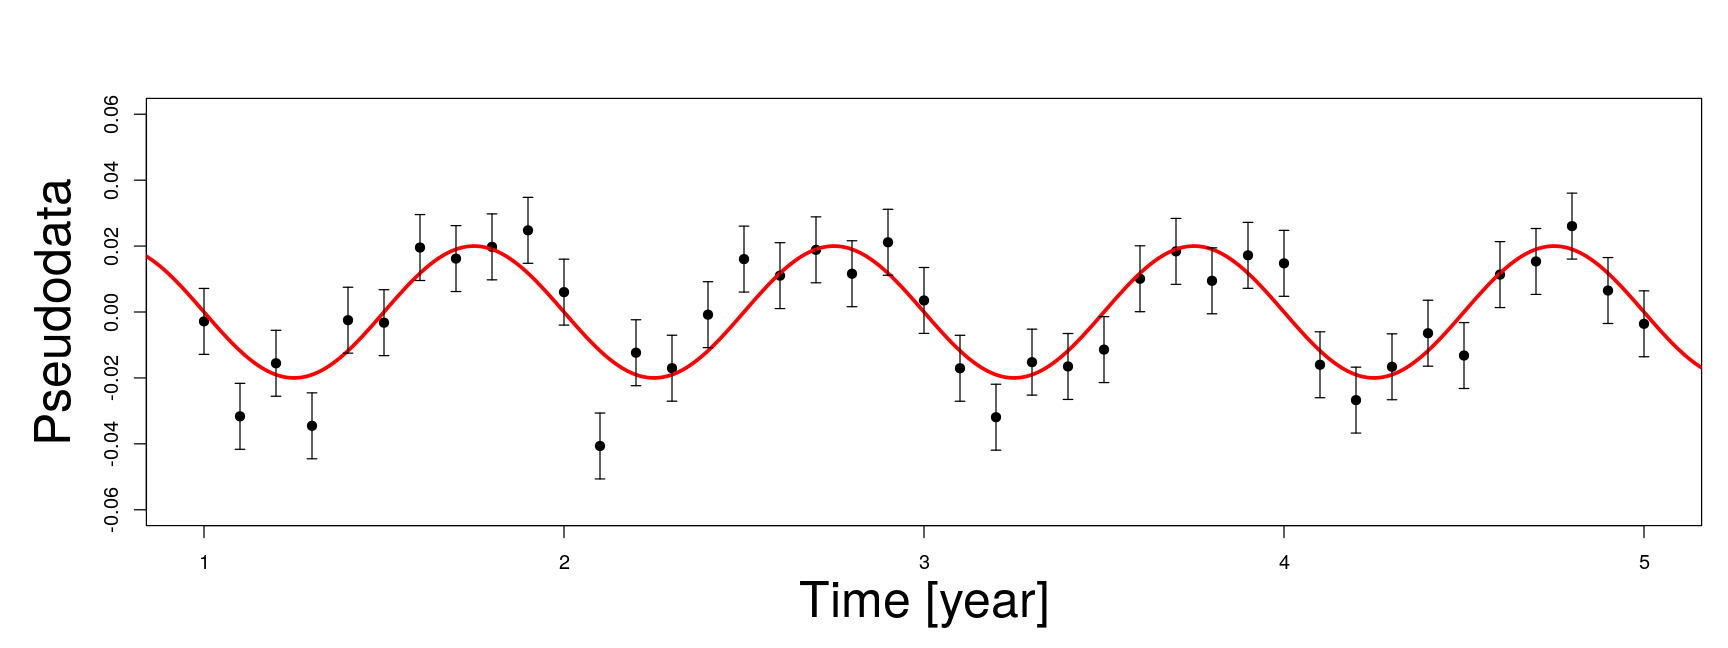

In [4]:
x<-seq(1,5, by = 0.1)
N <- length(x)

data   <- vector(mode = "list", length = 3)
sddata <- vector(mode = "list", length = 3)

sddata[[1]] <- rep(err, N) #first dataset errors
sddata[[2]] <- rep(err, N) #second dataset errors
sddata[[3]] <- rep(err, N) #third dataset errors

# The first data set is simulated using only COS modulation

tmp <- x
for (i in 1:N) {
    tmp[i] <- rnorm(1,
                     mean = rate_sim(x[i],
                                     SAW = 0,
                                     A = par_A,
                                     phi = par_phi,
                                     T = par_T),
                     sd = sddata[[1]][i])
}

data[[1]] <- tmp

par(mar=c(5,6,4,1)+.1)
options(repr.plot.width=8*1.8, repr.plot.height=3*1.8)

plot(x, data[[1]],
    pch=19, ylim = c(-3 * par_A , 3 * par_A),
    xlab = 'Time [year]',
    ylab = 'Pseudodata',
    cex.lab  = 2.5,
    cex.main = 3
)
tmp <- seq(0., 6., by = 1e-5)
lines(tmp, rate_sim(tmp, SAW = 0, A = par_A, phi = par_phi), col = 'red', lwd = 3)
arrows(x, data[[1]]-sddata[[1]], x, data[[1]]+sddata[[1]], length=0.04, angle=90, code=3)

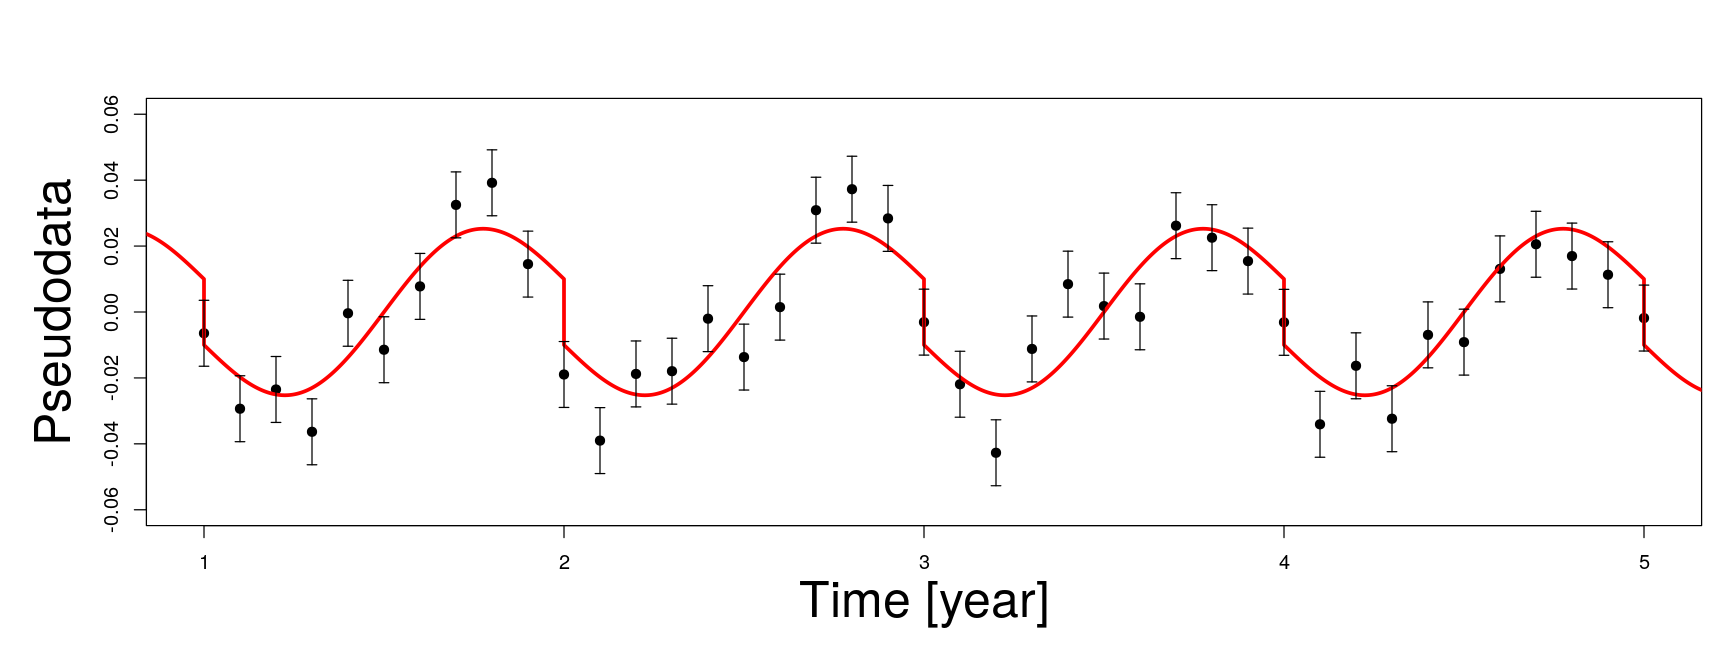

In [5]:
# The second data set is simulated using COS modulation plus SAW modulation

tmp <- x
for (i in 1:N) {
    tmp[i] <- rnorm(1,
                      mean = rate_sim(x[i],
                                      SAW = 1,
                                      B = par_B,
                                      A = par_A,
                                      phi = par_phi,
                                      T = par_T),
                      sd = sddata[[2]][i])
}
data[[2]] <- tmp


par(mar=c(5,6,4,1)+.1)

plot(x, data[[2]],
    pch=19, ylim = c(-3.*par_A , 3.*par_A),
    xlab = 'Time [year]',
    ylab = 'Pseudodata',
    cex.lab  = 2.5,
    cex.main = 3
)

tmp <- seq(0., 6., by = 1e-5)
lines(tmp, rate_sim(tmp, SAW = 1, B = par_B, A = par_A, phi = par_phi), col = 'red', lwd = 3)
arrows(x, data[[2]]-sddata[[2]], x, data[[2]]+sddata[[2]], length=0.04, angle=90, code=3)

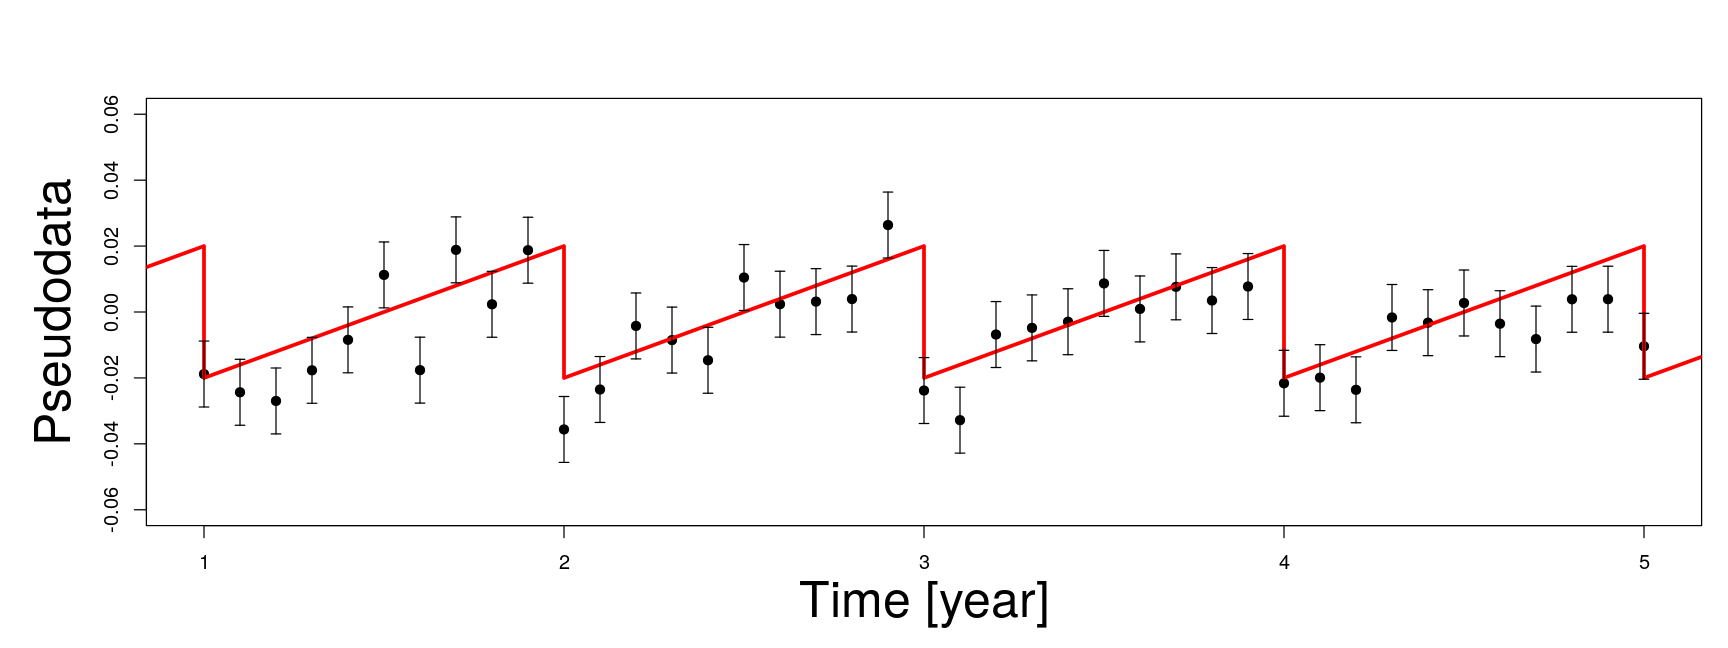

In [6]:
# The second data set is simulated using cos modulation plus sawtooth modulation

tmp <- x

for (i in 1:N) {
    tmp[i] <- rnorm(1,
                      mean = rate_sim(x[i],
                                      SAW = 1,
                                      B = par_Bosaw,
                                      A = 0,
                                      phi = 0,
                                      T = par_T),
                      sd = sddata[[3]][i])
}
data[[3]] <- tmp



par(mar=c(5,6,4,1)+.1)


plot(x, data[[3]],
    pch=19, ylim = c(-3.*par_A , 3.*par_A),
    xlab = 'Time [year]',
    ylab = 'Pseudodata',
    cex.lab  = 2.5,
    cex.main = 3
)

tmp <- seq(0., 6., by = 1e-5)
lines(tmp, rate_sim(tmp, SAW = 1, B = par_Bosaw, A = 0, phi = 0), col = 'red', lwd = 3)
arrows(x, data[[3]]-sddata[[3]], x, data[[3]]+sddata[[3]], length=0.04, angle=90, code=3)

In [7]:
fitInputTot = vector(mode = "list", length = 3*3)

In [8]:
# FITS OF THE PSEDUDATA WITH A COSINE (fixed phase and period to the real one)

modello_cos    <-    "COSfix.bug"

model_cos_init    <- list(A = par_A)

chains_cos   <- vector(mode = "list", length = 3)
mcmc_cos     <- vector(mode = "list", length = 3)

for (data_index in 1:3) {

    fitInput <- NULL

    fitInput$n      <- N
    fitInput$x      <- data[[data_index]]
    fitInput$sd     <- sddata[[data_index]]
    fitInput$t      <- x
    fitInput$T      <- par_T
    fitInput$phi    <- par_phi
    fitInput$pi     <- pi
    
    # prior parameters
    fitInput$max_A   <- max_A
   
    m_cos <- jags.model(modello_cos,
                    fitInput,
                    model_cos_init
                   )

    update(m_cos, 10000)                  # burn in 

    to.sample_cos = c('A')

    chains_cos[[data_index]] <- coda.samples(m_cos, to.sample_cos, n.iter=50000)  # sampling 
    
    mcmc_cos[[data_index]]   <- as.mcmc(chains_cos[[data_index]])

    fitInputTot[[data_index]] <- fitInput
}
print("Done.")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 1
   Total graph size: 304

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 1
   Total graph size: 304

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 1
   Total graph size: 304

Initializing model

[1] "Done."


## Result of the fit of the COS data with the COS model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     2.200e-02      2.250e-03      1.006e-05      1.304e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.01760 0.02048 0.02199 0.02351 0.02638 



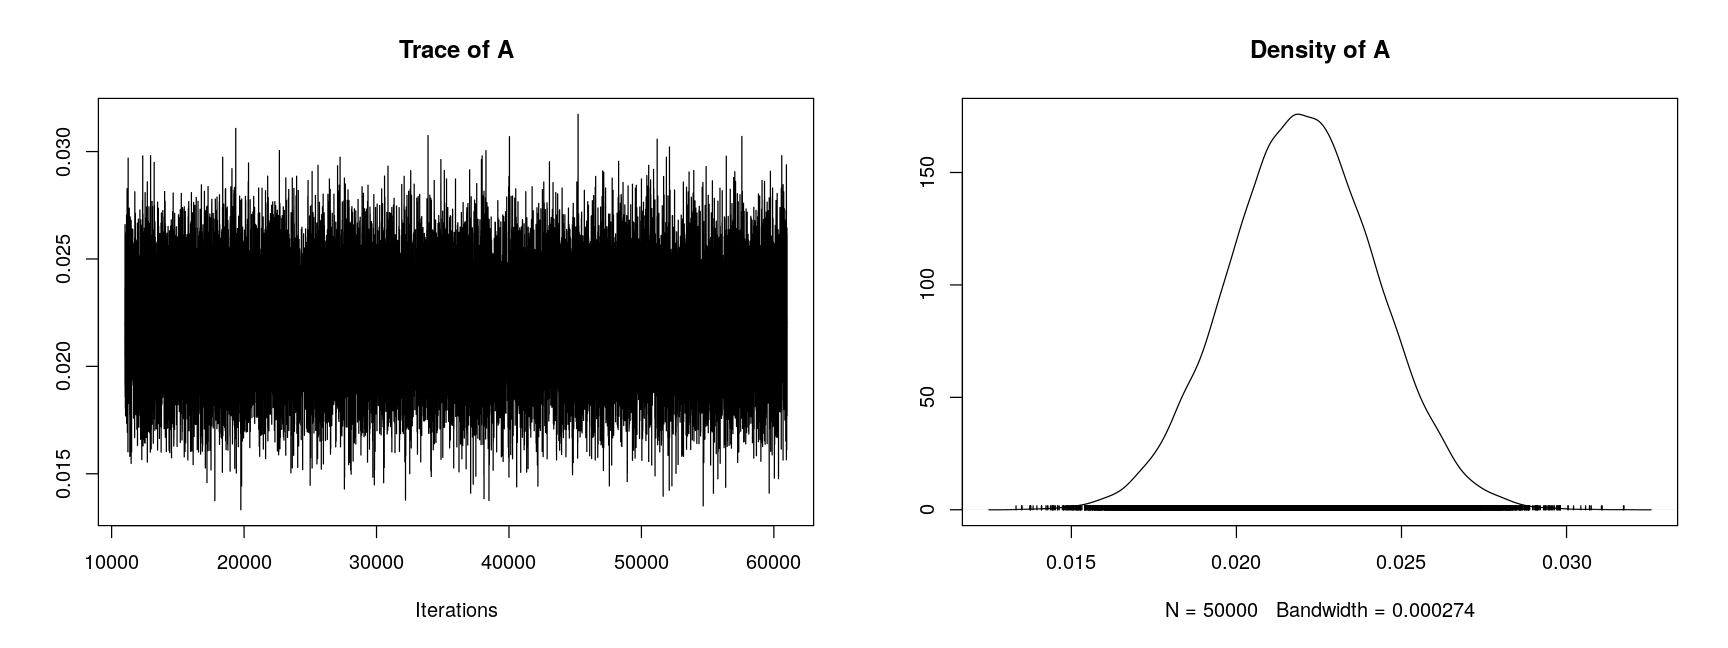

In [9]:
i <- 1
print(summary(chains_cos[[i]]))
plot(chains_cos[[i]])

## Result of the fit of the C+S data with the COS model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     2.655e-02      2.238e-03      1.001e-05      1.275e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.02213 0.02504 0.02655 0.02805 0.03092 



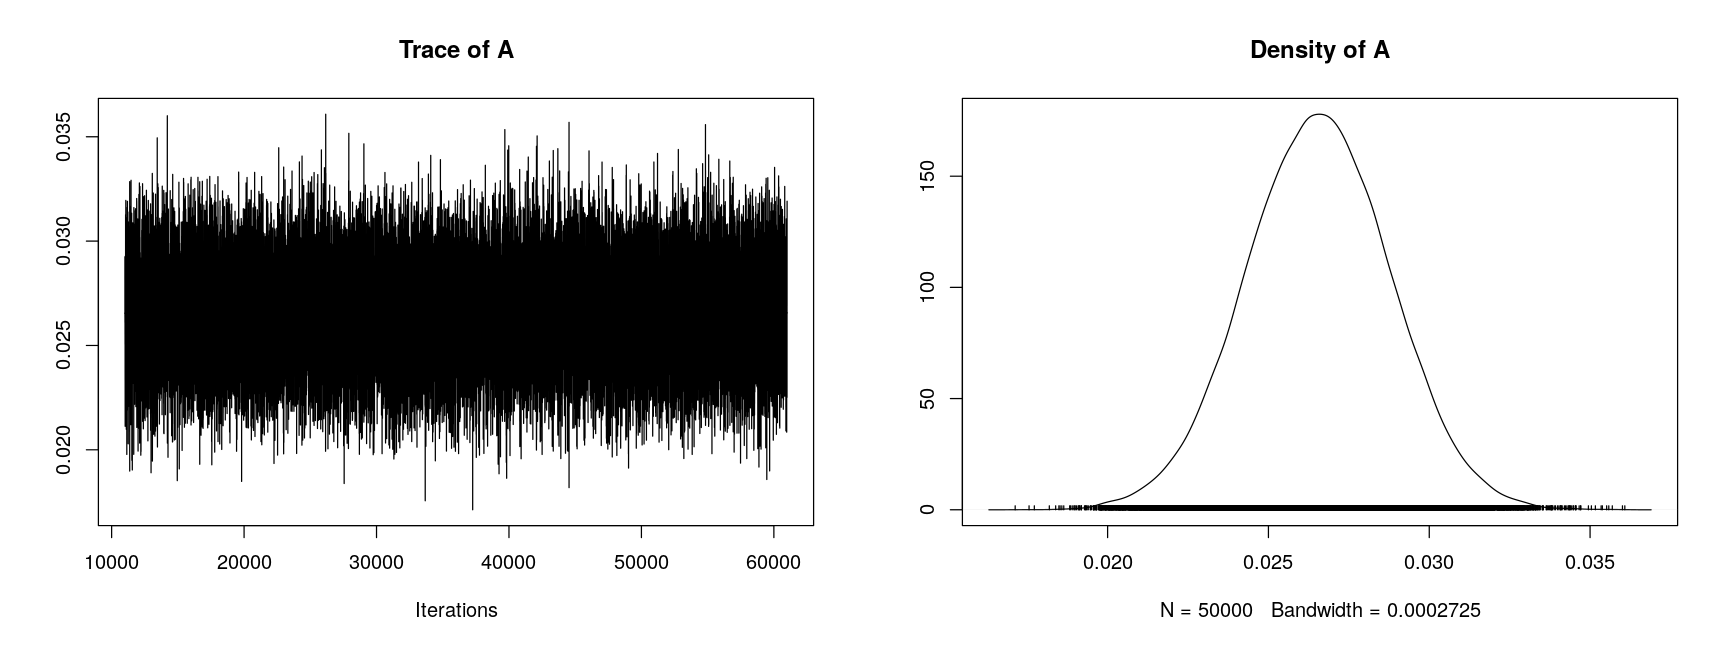

In [10]:
i <- 2
print(summary(chains_cos[[i]]))
plot(chains_cos[[i]])

## Result of the fit of the SAW data with the COS model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     1.110e-02      2.243e-03      1.003e-05      1.290e-05 

2. Quantiles for each variable:

    2.5%      25%      50%      75%    97.5% 
0.006721 0.009576 0.011111 0.012606 0.015490 



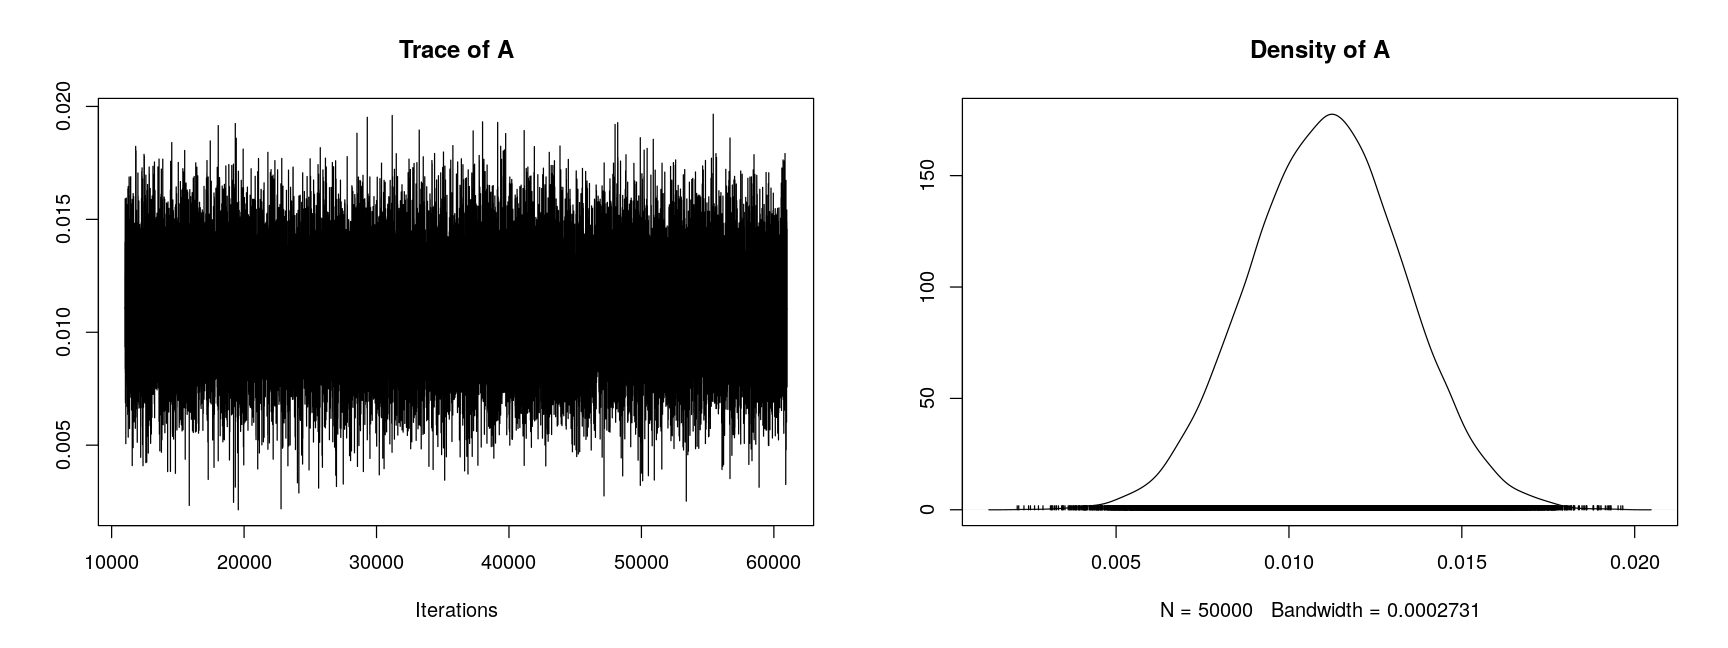

In [11]:
i <- 3
print(summary(chains_cos[[i]]))
plot(chains_cos[[i]])

In [12]:
# FITS OF THE PSEDUDATA WITH A PURE SAWTOOTH

modello_osaw    <-    "ONLYSAW.bug"

model_osaw_init    <- list(B = par_Bosaw)

chains_osaw   <- vector(mode = "list", length = 3)
mcmc_osaw     <- vector(mode = "list", length = 3)

for (data_index in 1:3) {

    fitInput <- NULL

    fitInput$n      <- N
    fitInput$x      <- data[[data_index]]
    fitInput$sd     <- sddata[[data_index]]
    fitInput$ft     <- x %% par_T - par_T/2
    
    # prior parameters
    fitInput$B_0       <- B_0
    fitInput$width_B   <- width_B
   
    m_osaw <- jags.model(modello_osaw,
                    fitInput,
                    model_osaw_init
                   )

    update(m_osaw, 10000)                  # burn in 

    to.sample_osaw = c('B')

    chains_osaw[[data_index]] <- coda.samples(m_osaw, to.sample_osaw, n.iter=50000)  # sampling 
    
    mcmc_osaw[[data_index]]   <- as.mcmc(chains_osaw[[data_index]])

    fitInputTot[[data_index+3]] <- fitInput
}
print("Done.")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 1
   Total graph size: 144

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 1
   Total graph size: 144

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 1
   Total graph size: 144

Initializing model

[1] "Done."


## Result of the fit of the COS data with the SAW model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     3.979e-02      5.261e-03      2.353e-05      2.931e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.02950 0.03621 0.03979 0.04334 0.05011 



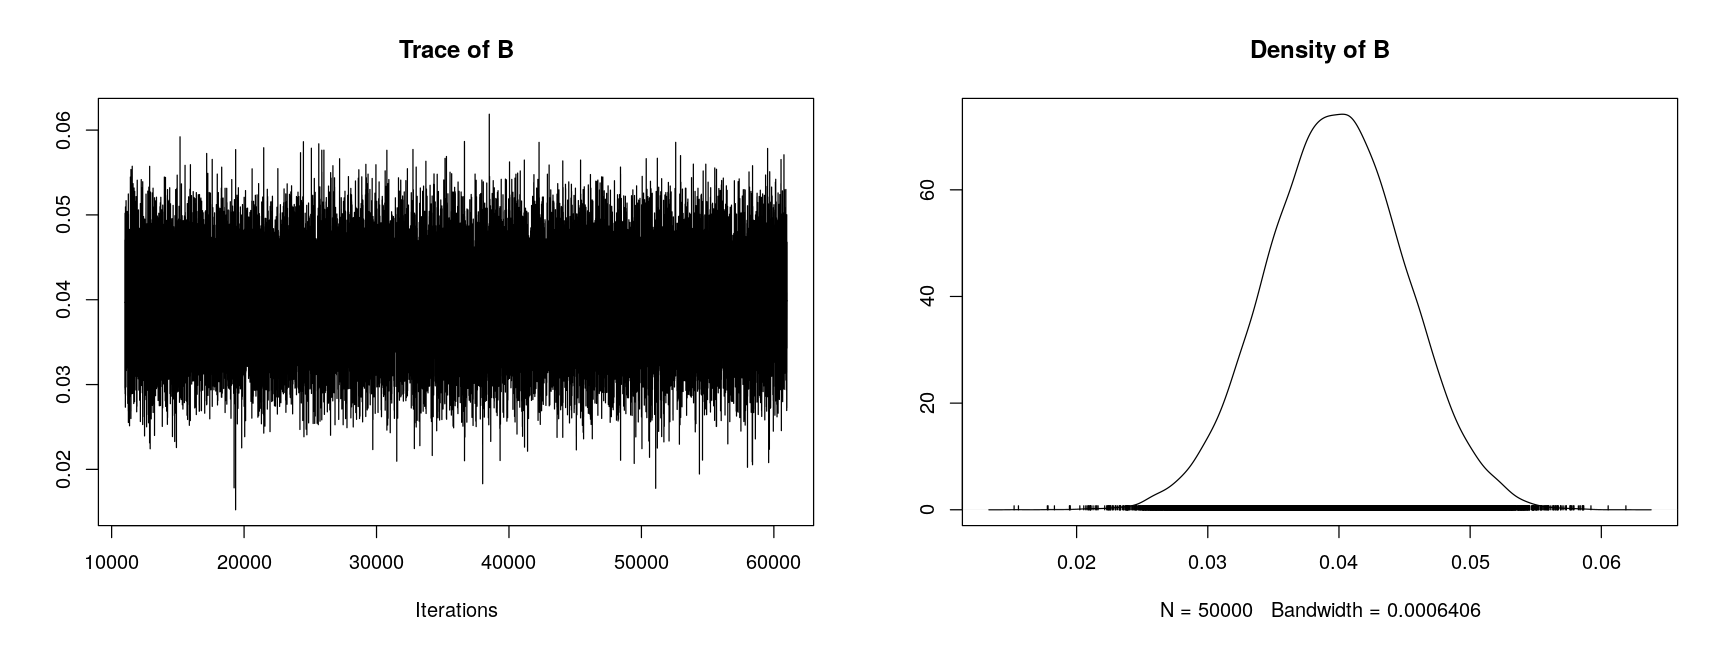

In [13]:
i <- 1
print(summary(chains_osaw[[i]]))
plot(chains_osaw[[i]])

## Result of the fit of the C+S data with the SAW model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.0557549      0.0052554      0.0000235      0.0000302 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.04548 0.05220 0.05577 0.05926 0.06613 



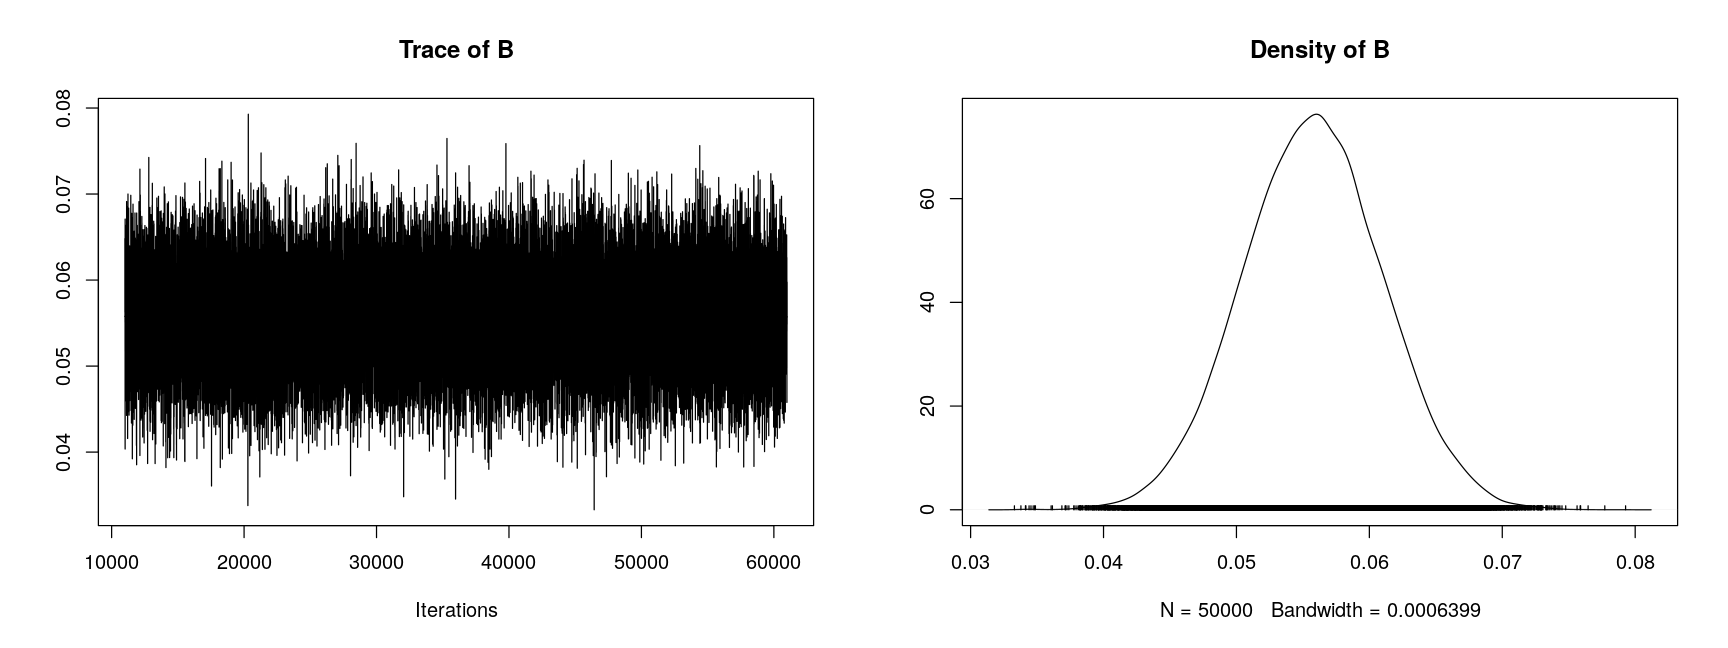

In [14]:
i <- 2
print(summary(chains_osaw[[i]]))
plot(chains_osaw[[i]])

## Result of the fit of the SAW data with the SAW model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     4.183e-02      5.206e-03      2.328e-05      2.941e-05 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
0.03163 0.03828 0.04187 0.04533 0.05194 



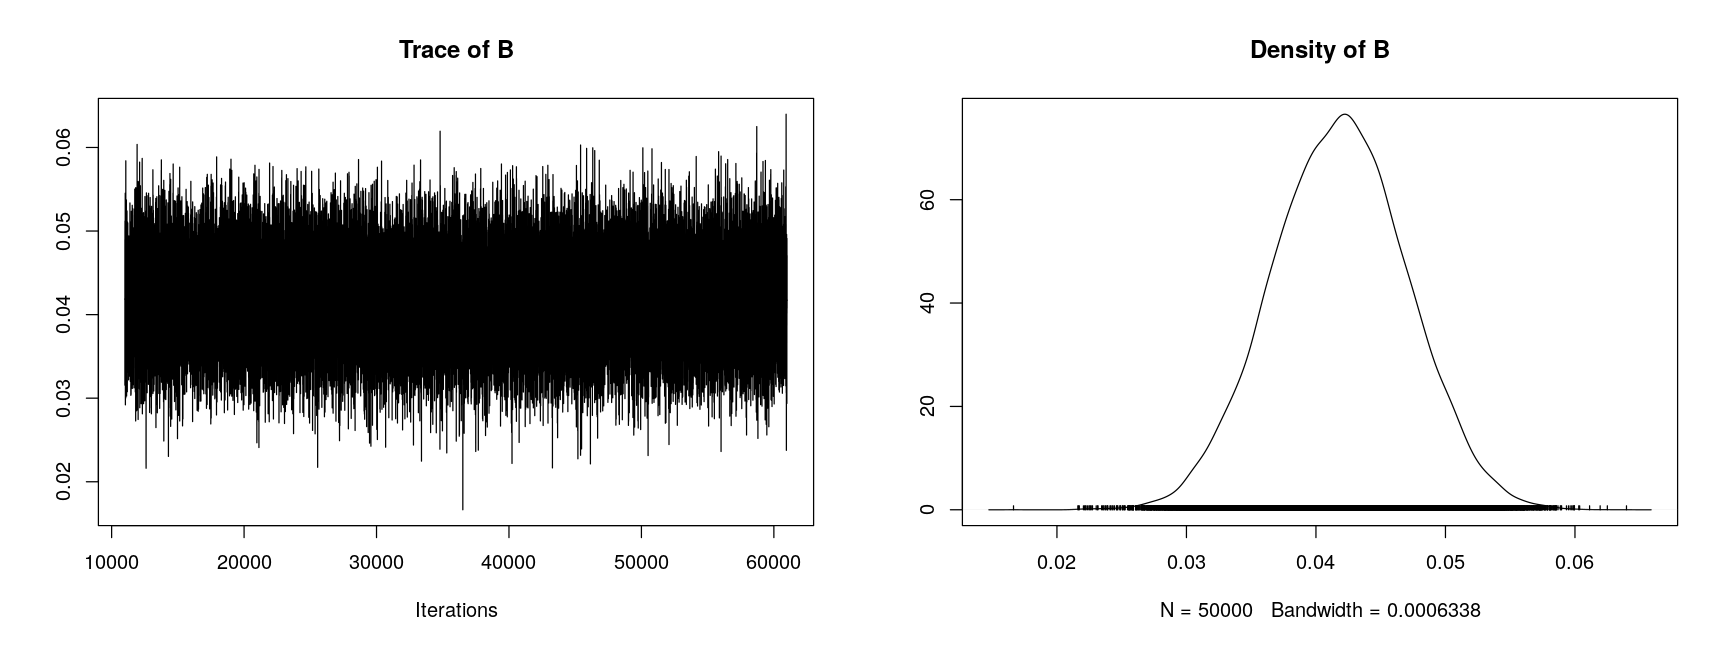

In [15]:
i <- 3
print(summary(chains_osaw[[i]]))
plot(chains_osaw[[i]])

In [16]:
# FITS OF THE PSEDUDATA WITH COS+SAW MODEL

modello_saw    <-    "SAWCOS.bug"

model_saw_init    <- list(A = par_A, B = par_B)

chains_saw   <- vector(mode = "list", length = 3)
mcmc_saw     <- vector(mode = "list", length = 3)

for (data_index in 1:3) {

    fitInput <- NULL

    fitInput$n      <- N
    fitInput$x      <- data[[data_index]]
    fitInput$sd     <- sddata[[data_index]]
    fitInput$t      <- x
    fitInput$ft     <- x %% par_T - par_T/2
    fitInput$T      <- par_T
    fitInput$phi    <- par_phi
    fitInput$pi     <- pi
    
    # prior parameters
    fitInput$max_A   <- max_A
    fitInput$B_0       <- B_0
    fitInput$width_B   <- width_B
   
    m_saw <- jags.model(modello_saw,
                    fitInput,
                    model_saw_init
                   )

    update(m_saw, 10000)                  # burn in 

    to.sample_saw = c('A','B')

    chains_saw[[data_index]] <- coda.samples(m_saw, to.sample_saw, n.iter=50000)  # sampling 
    
    mcmc_saw[[data_index]]   <- as.mcmc(chains_saw[[data_index]])

    fitInputTot[[data_index+3*2]] <- fitInput
}
print("Done.")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 2
   Total graph size: 373

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 2
   Total graph size: 373

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 2
   Total graph size: 373

Initializing model

[1] "Done."


## Result of the fit of the COS data with the C+S model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
A 0.020206 0.003251 1.454e-05      3.334e-05
B 0.005764 0.007592 3.395e-05      7.819e-05

2. Quantiles for each variable:

       2.5%       25%      50%     75%   97.5%
A  0.013834 0.0180059 0.020195 0.02241 0.02656
B -0.009167 0.0006779 0.005786 0.01088 0.02064



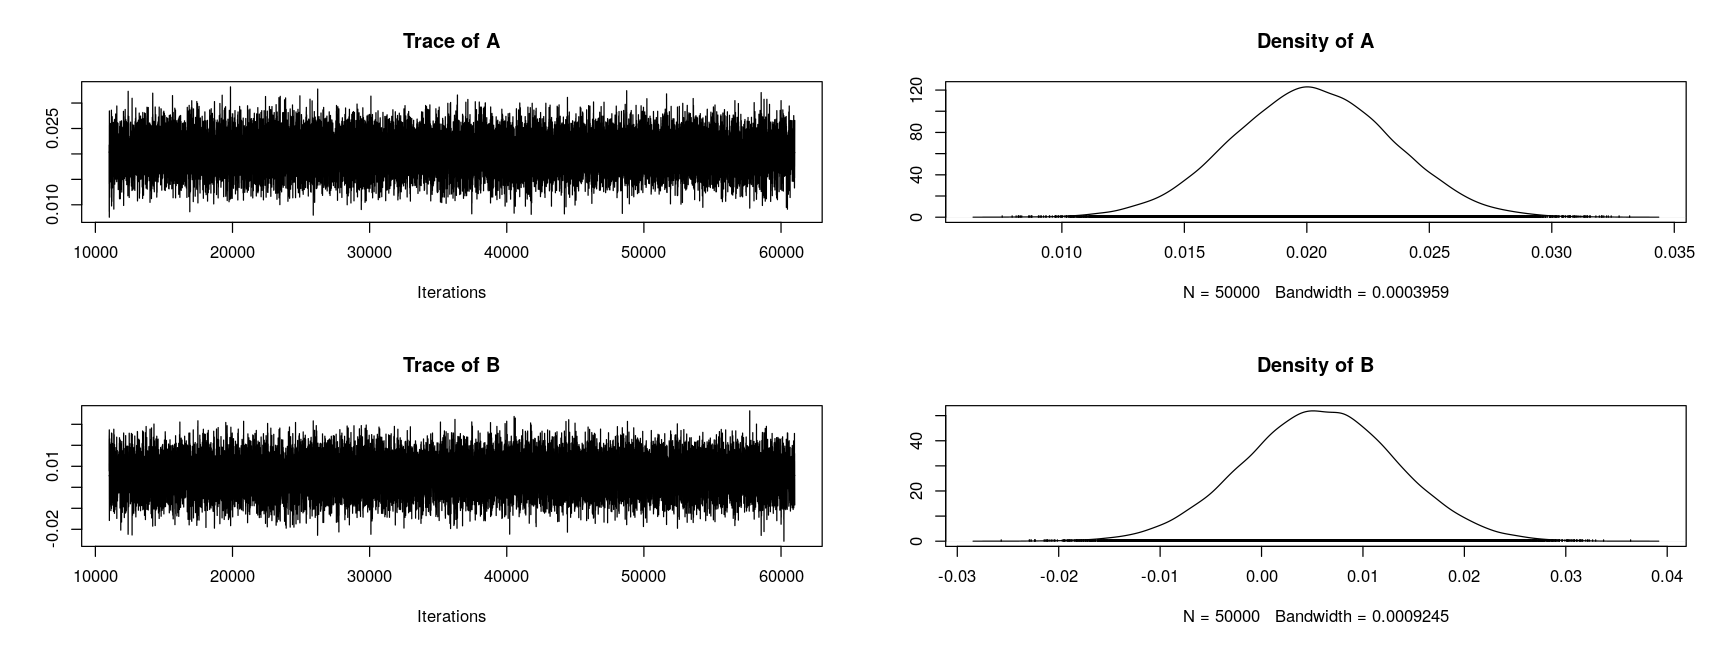

In [17]:
i <- 1
print(summary(chains_saw[[i]]))
plot(chains_saw[[i]])

## Result of the fit of the C+S data with the C+S model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean       SD  Naive SE Time-series SE
A 0.01957 0.003258 1.457e-05      3.258e-05
B 0.02269 0.007611 3.404e-05      7.682e-05

2. Quantiles for each variable:

      2.5%     25%     50%     75%   97.5%
A 0.013210 0.01737 0.01955 0.02175 0.02599
B 0.007738 0.01758 0.02270 0.02782 0.03744



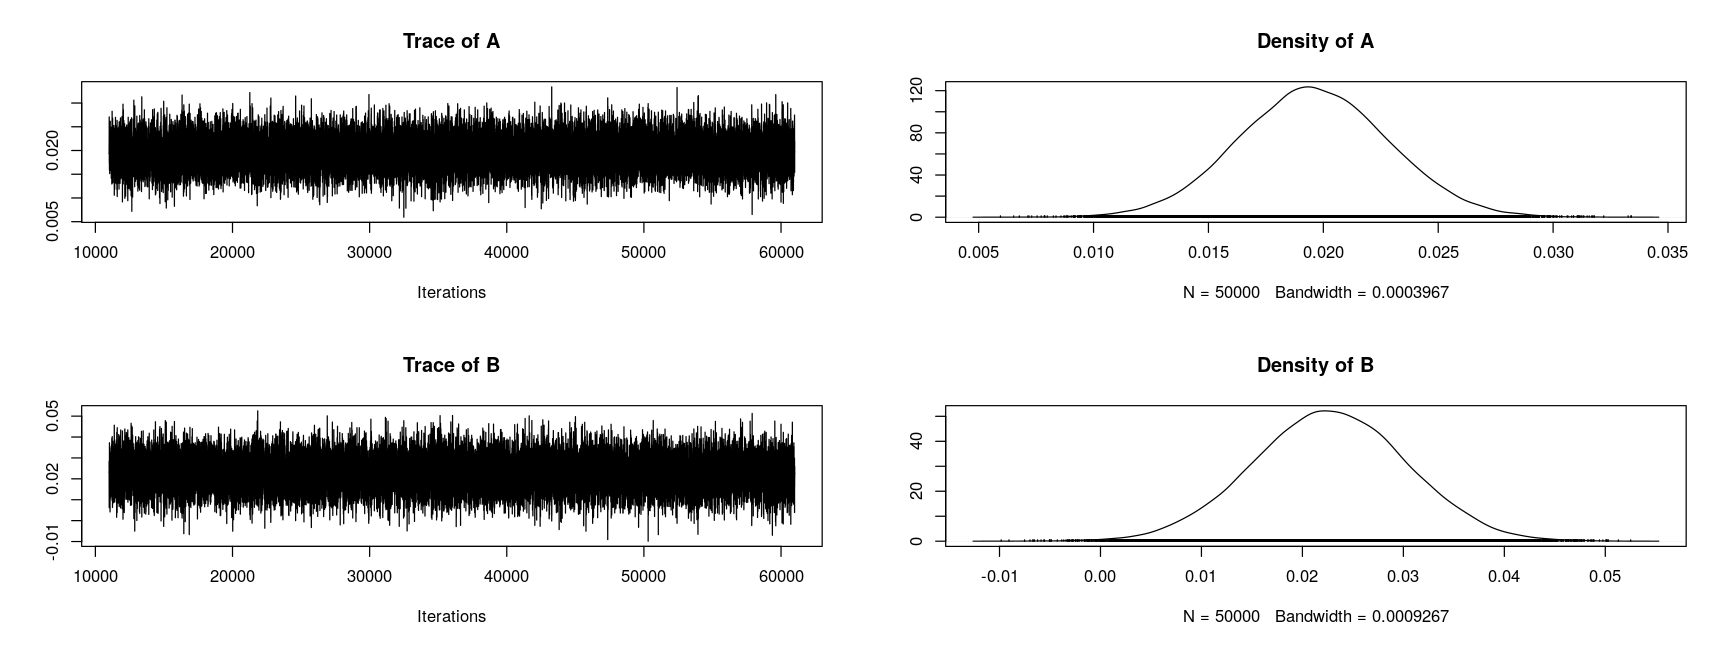

In [18]:
i <- 2
print(summary(chains_saw[[i]]))
plot(chains_saw[[i]])

## Result of the fit of the SAW data with the SAW model


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
A 0.001611 0.001381 6.174e-06      1.246e-05
B 0.039029 0.005726 2.561e-05      4.097e-05

2. Quantiles for each variable:

       2.5%       25%      50%      75%    97.5%
A 5.059e-05 0.0005442 0.001253 0.002313 0.005124
B 2.752e-02 0.0352500 0.039141 0.042921 0.050071



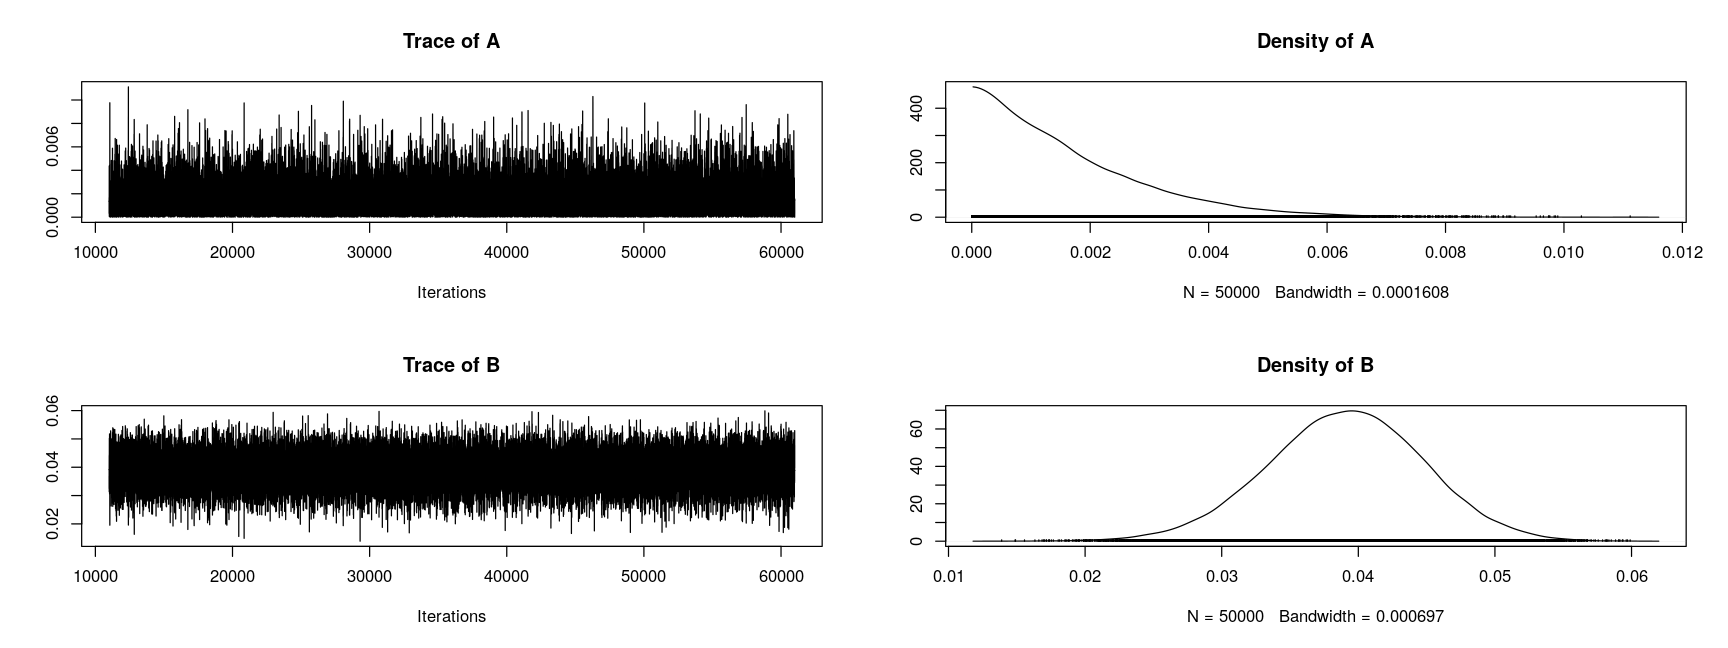

In [19]:
i <- 3
print(summary(chains_saw[[i]]))
plot(chains_saw[[i]])

# FIT RESULTS

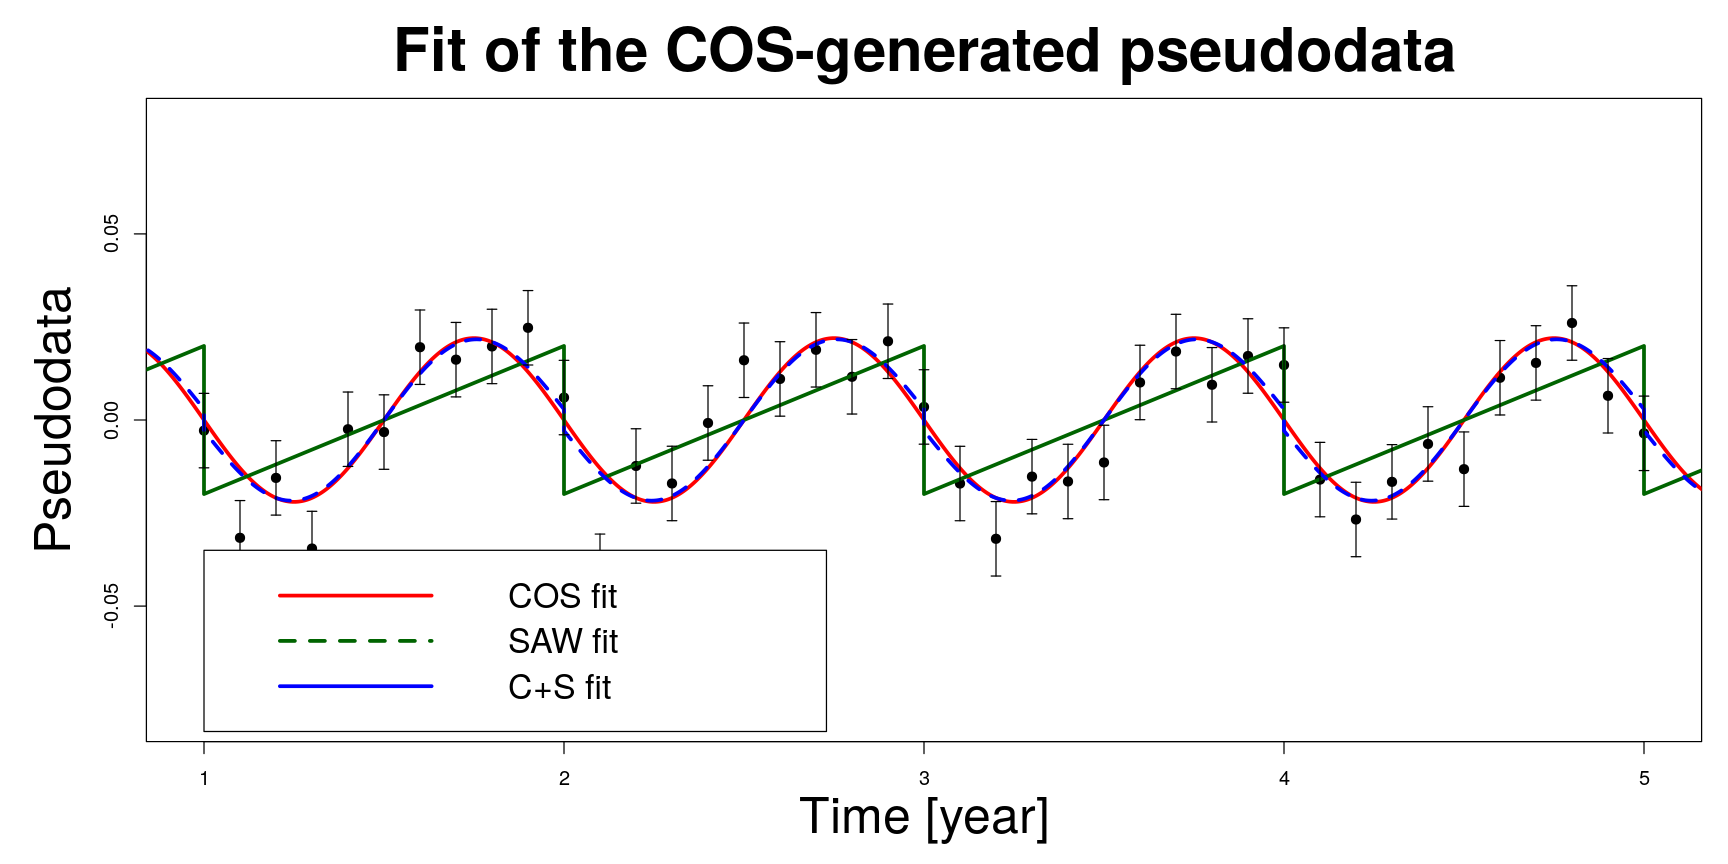

In [20]:
i<- 1

par(mar=c(5,6,4,1)+.1)
options(repr.plot.width=8*1.8, repr.plot.height=4*1.8)
plot(x, data[[i]],
    pch=19, ylim = c(-4.*par_A , 4.*par_A),
    main = "Fit of the COS-generated pseudodata",
    xlab = 'Time [year]',
    ylab = 'Pseudodata',
    cex.lab  = 2.5,
    cex.main = 3
)

tmp <- seq(0., 6., by = 1e-5)


lines(tmp, rate_sim(tmp, SAW = 0, A = mean(mcmc_cos[[i]][,"A"]), phi = par_phi, T = par_T),
      col = "red", lwd = 3)


lines(tmp, rate_sim(tmp, SAW = 1, B = mean(mcmc_osaw[[i]][,"B"]), A = 0, phi = 0),
      col = 'darkgreen', lwd = 3)

lines(tmp, rate_sim(tmp, SAW = 1, A = mean(mcmc_saw[[i]][,"A"]),
                    B = mean(mcmc_saw[[i]][,"B"]), phi = par_phi, T = par_T),
      col = "blue", lwd = 3, lty = 2)


arrows(x, data[[i]]-sddata[[i]][i], x, data[[i]]+sddata[[i]][i], length=0.04, angle=90, code=3)

legend(1, -0.035, legend=c("COS fit",
                          "SAW fit",
                          "C+S fit"),
       col=c("red", "darkgreen", "blue"), lty=1:1:2, lwd = 3,
      cex = 1.7)

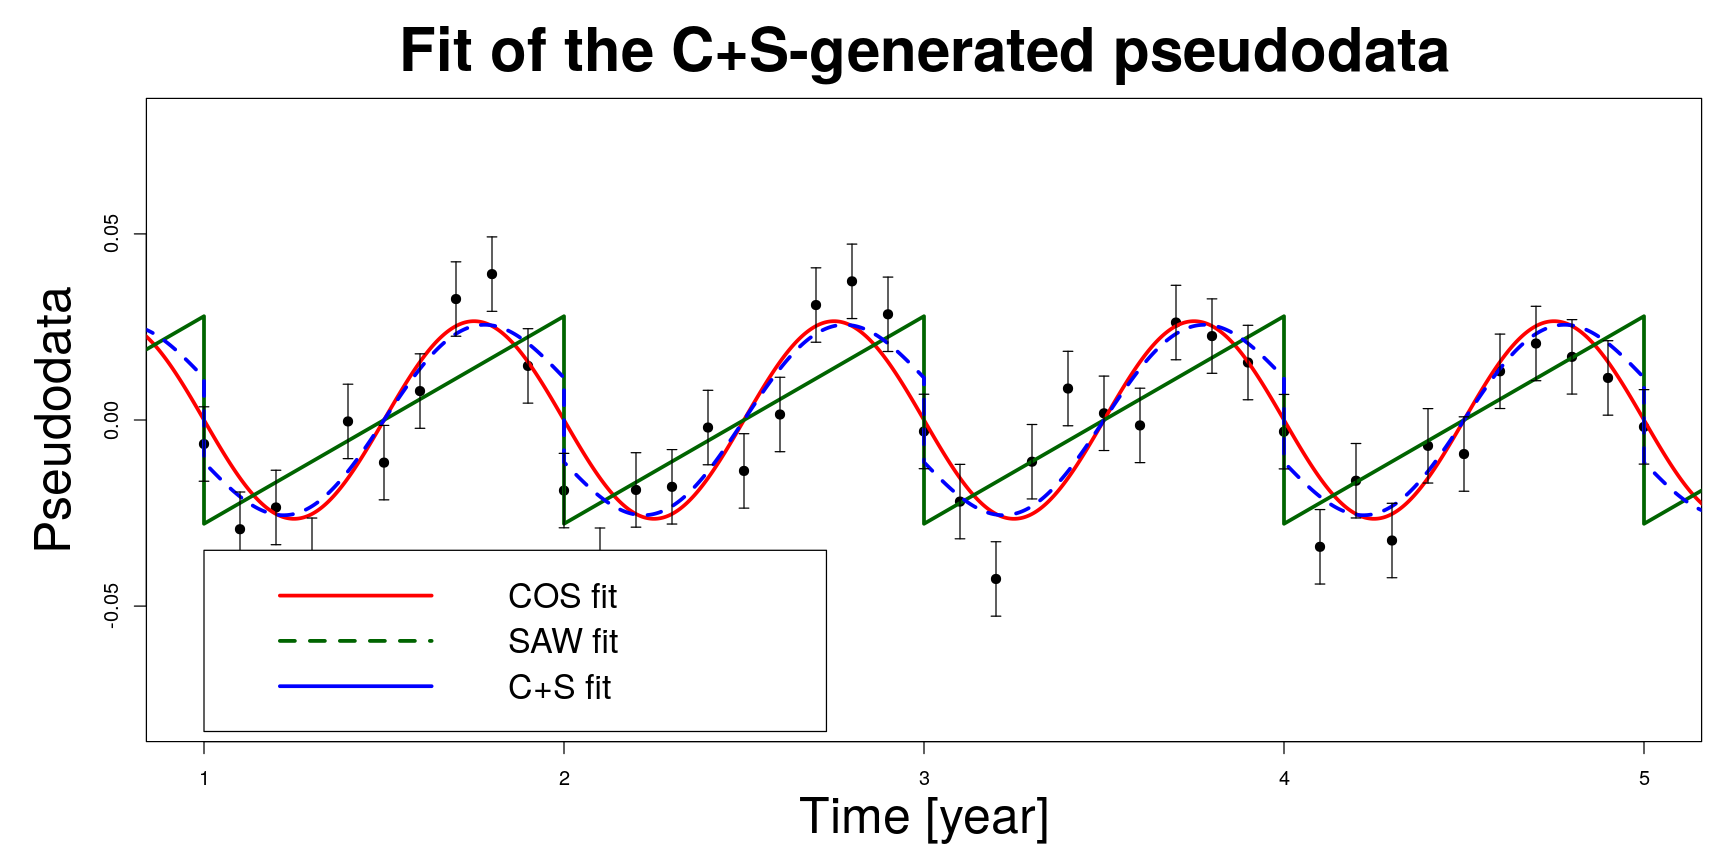

In [21]:
i<- 2

par(mar=c(5,6,4,1)+.1)
options(repr.plot.width=8*1.8, repr.plot.height=4*1.8)
plot(x, data[[i]],
    pch=19, ylim = c(-4.*par_A , 4.*par_A),
    main = "Fit of the C+S-generated pseudodata",
    xlab = 'Time [year]',
    ylab = 'Pseudodata',
    cex.lab  = 2.5,
    cex.main = 3
)

tmp <- seq(0., 6., by = 1e-5)


lines(tmp, rate_sim(tmp, SAW = 0, A = mean(mcmc_cos[[i]][,"A"]), phi = par_phi, T = par_T),
      col = "red", lwd = 3)


lines(tmp, rate_sim(tmp, SAW = 1, B = mean(mcmc_osaw[[i]][,"B"]), A = 0, phi = 0),
      col = 'darkgreen', lwd = 3)

lines(tmp, rate_sim(tmp, SAW = 1, A = mean(mcmc_saw[[i]][,"A"]),
                    B = mean(mcmc_saw[[i]][,"B"]), phi = par_phi, T = par_T),
      col = "blue", lwd = 3, lty = 2)


arrows(x, data[[i]]-sddata[[i]][i], x, data[[i]]+sddata[[i]][i], length=0.04, angle=90, code=3)

legend(1, -0.035, legend=c("COS fit",
                          "SAW fit",
                          "C+S fit"),
       col=c("red", "darkgreen", "blue"), lty=1:1:2, lwd = 3,
      cex = 1.7)

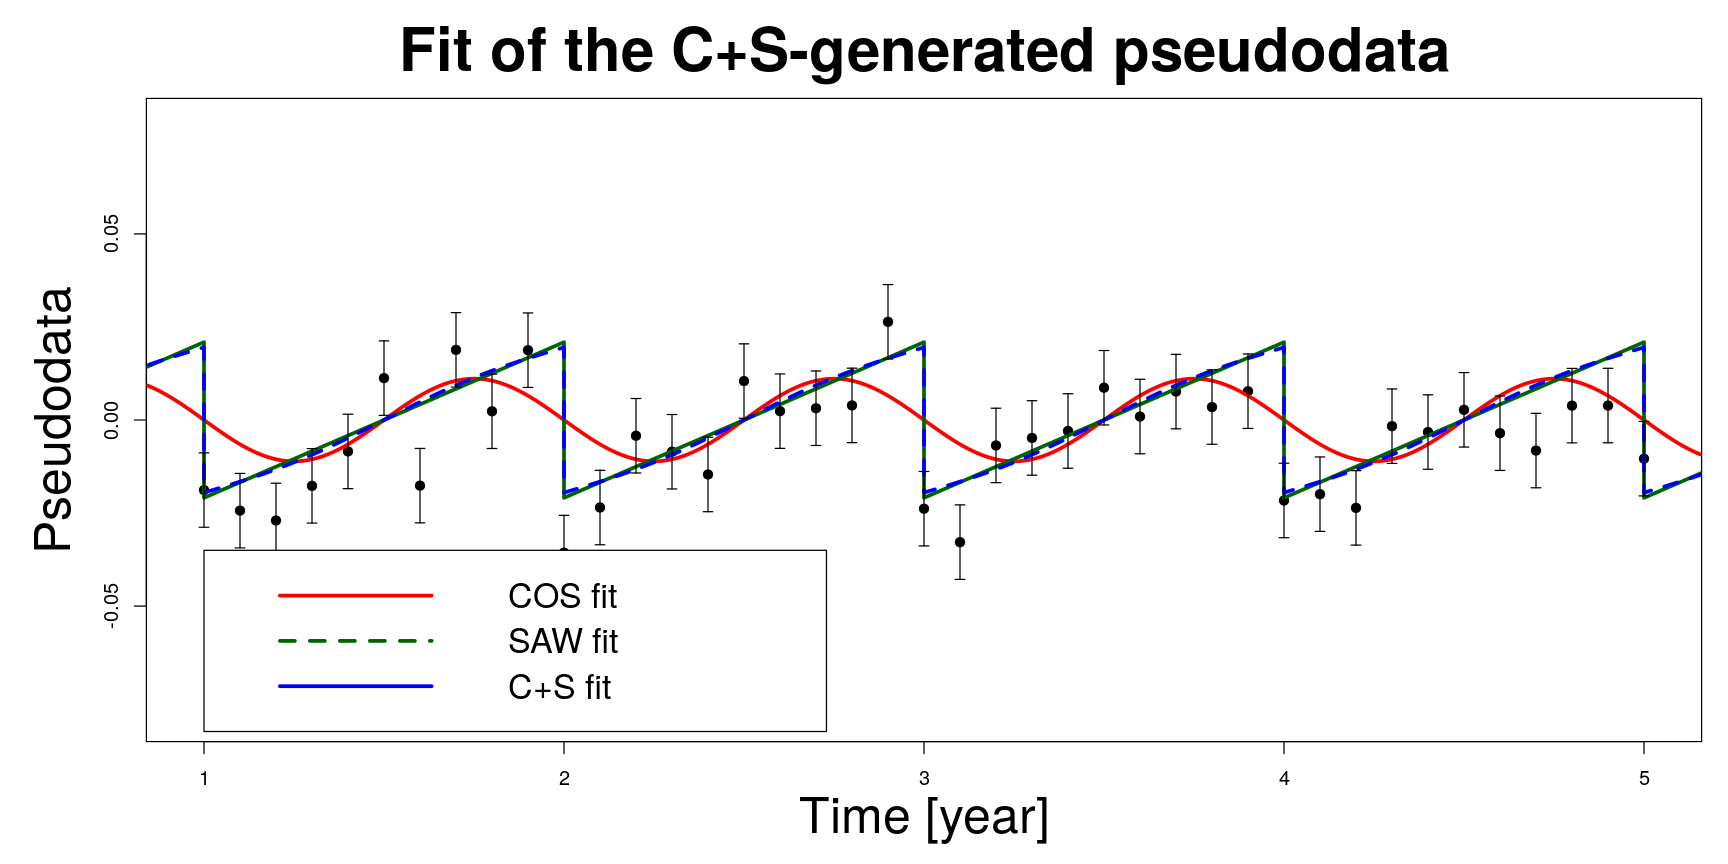

In [22]:
i<- 3

par(mar=c(5,6,4,1)+.1)
options(repr.plot.width=8*1.8, repr.plot.height=4*1.8)
plot(x, data[[i]],
    pch=19, ylim = c(-4.*par_A , 4.*par_A),
    main = "Fit of the C+S-generated pseudodata",
    xlab = 'Time [year]',
    ylab = 'Pseudodata',
    cex.lab  = 2.5,
    cex.main = 3
)

tmp <- seq(0., 6., by = 1e-5)


lines(tmp, rate_sim(tmp, SAW = 0, A = mean(mcmc_cos[[i]][,"A"]), phi = par_phi, T = par_T),
      col = "red", lwd = 3)


lines(tmp, rate_sim(tmp, SAW = 1, B = mean(mcmc_osaw[[i]][,"B"]), A = 0, phi = 0),
      col = 'darkgreen', lwd = 3)

lines(tmp, rate_sim(tmp, SAW = 1, A = mean(mcmc_saw[[i]][,"A"]),
                    B = mean(mcmc_saw[[i]][,"B"]), phi = par_phi, T = par_T),
      col = "blue", lwd = 3, lty = 2)


arrows(x, data[[i]]-sddata[[i]][i], x, data[[i]]+sddata[[i]][i], length=0.04, angle=90, code=3)

legend(1, -0.035, legend=c("COS fit",
                          "SAW fit",
                          "C+S fit"),
       col=c("red", "darkgreen", "blue"), lty=1:1:2, lwd = 3,
      cex = 1.7)

In [23]:
# Likelihoods computation

L_COS     <- vector(mode = "list", length = 3)
L_OSAW    <- vector(mode = "list", length = 3)
L_SAW     <- vector(mode = "list", length = 3)

for(i in (1:3)) {
    L_COS[[i]] <- 1
    for (j in 1:N) {
        L_COS[[i]] <- L_COS[[i]] * dnorm(data[[i]][j],
                                         mean = rate_sim(x[j],
                                                         SAW = 0,
                                                         A   = mean(mcmc_cos[[i]][,"A"]),
                                                         phi = par_phi,
                                                         T   = par_T),
                                         sd = sddata[[i]][j])
    }
    
    L_OSAW[[i]] <- 1
    for (j in 1:N) {
        L_OSAW[[i]] <- L_OSAW[[i]] * dnorm(data[[i]][j],
                                         mean = rate_sim(x[j],
                                                         SAW = 1,
                                                         B   = mean(mcmc_osaw[[i]][,"B"]),
                                                         A   = 0,
                                                         phi = par_phi,
                                                         T   = par_T),
                                         sd = sddata[[i]][j])
    }
    
    L_SAW[[i]] <- 1
    for (j in 1:N) {
        L_SAW[[i]] <- L_SAW[[i]] * dnorm(data[[i]][j],
                                         mean = rate_sim(x[j],
                                                         SAW = 1,
                                                         B   = mean(mcmc_saw[[i]][,"B"]),
                                                         A   = mean(mcmc_saw[[i]][,"A"]),
                                                         phi = par_phi,
                                                         T   = par_T),
                                         sd = sddata[[i]][j])
    }
}

In [24]:
# Ockham exstimation

O_COS     <- vector(mode = "list", length = 3)
O_OSAW    <- vector(mode = "list", length = 3)
O_SAW     <- vector(mode = "list", length = 3)

for(i in (1:3)) {
    
    O_COS[[i]]  <- sqrt(2*pi)*sd(mcmc_cos[[i]][,"A"])/(max_A);
    
    O_OSAW[[i]] <- sqrt(2*pi)*sd(mcmc_osaw[[i]][,"B"])/(2*width_B);
    
    O_SAW[[i]]  <- sqrt(2*pi)^2 *
                    sd(mcmc_saw[[i]][,"A"])*sd(mcmc_saw[[i]][,"B"])/
                    ((2 * width_B) * max_A);
}

# First estimation of BF

## Fit on COS generated pseudodata

In [25]:
i <- 1

comparisons <- c("COS vs SAW", "COS vs C+S", "SAW VS C+S")

LR          <- c(
                 10 * log10(L_COS[[i]]/L_OSAW[[i]]),
                 10 * log10(L_COS[[i]]/L_SAW[[i]]),
                 10 * log10(L_OSAW[[i]]/L_SAW[[i]])
                )

OF          <- c(
                 10 * log10(O_COS[[i]]/O_OSAW[[i]]),
                 10 * log10(O_COS[[i]]/O_SAW[[i]]),
                 10 * log10(O_OSAW[[i]]/O_SAW[[i]])
                )

BF          <- LR + OF

DELTABIC    <- log(N) * c(1-1, 1-2, 1-2) - 2 * log(10 ^ (LR/10))

DELTAAIC    <- 2 * c(1-1, 1-2, 1-2) - 2 * log(10 ^ (LR/10))

cos.df <- data.frame(comparisons, BF, LR, OF, DELTABIC, DELTAAIC)

colnames(cos.df) <- c("Comp", "BF [dB]", "LR [dB]", "OF [dB]", "D_BIC", "D_AIC")
cat(sprintf("\n\n"))
print(cos.df)
cat(sprintf("\n\n"))



        Comp    BF [dB]    LR [dB]  OF [dB]      D_BIC     D_AIC
1 COS vs SAW  86.395091  84.062942 2.332148 -38.712416 -38.71242
2 COS vs C+S   7.360121  -1.257282 8.617402  -3.134573  -1.42100
3 SAW VS C+S -79.034970 -85.320224 6.285254  35.577843  37.29142




## Fit on C+S generated pseudodata

In [26]:
i <- 2

comparisons <- c("COS vs SAW", "COS vs C+S", "SAW VS C+S")

LR          <- c(
                 10 * log10(L_COS[[i]]/L_OSAW[[i]]),
                 10 * log10(L_COS[[i]]/L_SAW[[i]]),
                 10 * log10(L_OSAW[[i]]/L_SAW[[i]])
                )

OF          <- c(
                 10 * log10(O_COS[[i]]/O_OSAW[[i]]),
                 10 * log10(O_COS[[i]]/O_SAW[[i]]),
                 10 * log10(O_OSAW[[i]]/O_SAW[[i]])
                )

BF          <- LR + OF

DELTABIC    <- log(N) * c(1-1, 1-2, 1-2) - 2 * log(10 ^ (LR/10))

DELTAAIC    <- 2 * c(1-1, 1-2, 1-2) - 2 * log(10 ^ (LR/10))

saw.df <- data.frame(comparisons, BF, LR, OF, DELTABIC, DELTAAIC)

colnames(saw.df) <- c("Comp", "BF [dB]", "LR [dB]", "OF [dB]", "D_BIC", "D_AIC")
cat(sprintf("\n\n"))
print(saw.df)
cat(sprintf("\n\n"))



        Comp   BF [dB]   LR [dB]  OF [dB]      D_BIC      D_AIC
1 COS vs SAW  62.90057  60.58802 2.312557 -27.901813 -27.901813
2 COS vs C+S -11.00122 -19.57445 8.573231   5.300797   7.014369
3 SAW VS C+S -73.90180 -80.16247 6.260675  33.202610  34.916182




## Fit on SAW generated pseudodata

In [27]:
i <- 3

comparisons <- c("COS vs SAW", "COS vs C+S", "SAW VS C+S")

LR          <- c(
                 10 * log10(L_COS[[i]]/L_OSAW[[i]]),
                 10 * log10(L_COS[[i]]/L_SAW[[i]]),
                 10 * log10(L_OSAW[[i]]/L_SAW[[i]])
                )

OF          <- c(
                 10 * log10(O_COS[[i]]/O_OSAW[[i]]),
                 10 * log10(O_COS[[i]]/O_SAW[[i]]),
                 10 * log10(O_OSAW[[i]]/O_SAW[[i]])
                )

BF          <- LR + OF

DELTABIC    <- log(N) * c(1-1, 1-2, 1-2) - 2 * log(10 ^ (LR/10))

DELTAAIC    <- 2 * c(1-1, 1-2, 1-2) - 2 * log(10 ^ (LR/10))

osaw.df <- data.frame(comparisons, BF, LR, OF, DELTABIC, DELTAAIC)

colnames(osaw.df) <- c("Comp", "BF [dB]", "LR [dB]", "OF [dB]", "D_BIC", "D_AIC")
cat(sprintf("\n\n"))
print(osaw.df)
cat(sprintf("\n\n"))



        Comp   BF [dB]    LR [dB]   OF [dB]     D_BIC     D_AIC
1 COS vs SAW -82.59915 -84.963565  2.364417 39.127168 39.127168
2 COS vs C+S -68.41267 -81.961284 13.548612 34.030994 35.744566
3 SAW VS C+S  14.18648   3.002281 11.184195 -5.096174 -3.382601




In [28]:
library(bridgesampling)
library(R2jags)
library(mcmcplots)


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


Registered S3 method overwritten by 'mcmcplots':
  method        from  
  as.mcmc.rjags R2jags



In [29]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_cos <- function(pars, data) {
      
      
  A   <- pars["A"]

    
  sig <- A * cos(2. * pi * data$t / data$T + par_phi )


  out <-
      dunif(A, 0.0, data$max_A, log = TRUE) +            # prior
      sum(dnorm(data$x, sig, data$sd, log = TRUE))       # likelihood

 return(out)  
}


log_posterior_osaw <- function(pars, data) {
      
  B   <- pars["B"]

    
  bkg <- B * data$ft

  out <-
      dunif(B, data$B_0 - data$width_B, data$B_0 + data$width_B, log = TRUE) + # prior
      sum(dnorm(data$x, bkg, data$sd, log = TRUE))                             # likelihood

 return(out)  
}


log_posterior_saw <- function(pars, data) {
      
      
  A   <- pars["A"]
  B   <- pars["B"]

    
  sig <- A * cos(2. * pi * data$t / data$T + par_phi)
  bkg <- B*data$ft

    out <-
      dunif(A, 0.0, data$max_A, log = TRUE) +                                   # prior
      dunif(B, data$B_0 - data$width_B, data$B_0 + data$width_B, log = TRUE) +  # prior
      sum(dnorm(data$x, sig+bkg, data$sd, log = TRUE))                          # likelihood

 return(out)  
}


In [30]:
# specify parameter bounds for COS
cn <- c("A")
lb_cos <- rep(0, length(cn))
ub_cos <- rep(0, length(cn))
names(lb_cos) <- names(ub_cos) <- cn
fitIn <- fitInputTot[[1]]
lb_cos["A"] = 0.0
ub_cos["A"] = fitIn$max_A 

# specify parameter bounds for SAW
cn <- c("B")
lb_osaw <- rep(0, length(cn))
ub_osaw <- rep(0, length(cn))
names(lb_osaw) <- names(ub_osaw) <- cn
fitIn <- fitInputTot[[1+3]]
lb_osaw["B"] = fitIn$B_0 - fitIn$width_B
ub_osaw["B"] = fitIn$B_0 + fitIn$width_B

# specify parameter bounds for C+S
cn <- c("A","B")
lb_saw <- rep(0, length(cn))
ub_saw <- rep(0, length(cn))
names(lb_saw) <- names(ub_saw) <- cn
fitIn <- fitInputTot[[1+3*2]]
lb_saw["A"] = 0.0 
ub_saw["A"] = fitIn$max_A 
lb_saw["B"] = fitIn$B_0 - fitIn$width_B
ub_saw["B"] = fitIn$B_0 + fitIn$width_B

In [31]:
# compute log marginal likelihood via bridge sampling for COS

cos.bridge <- vector(mode = "list", length = 3)

for (i in 1:3) {
    fitIn <- fitInputTot[[i]]
    tmp.chain <- chains_cos[[i]]
    
    tmp.bridge <- bridge_sampler(samples = tmp.chain, data = fitIn,
                            log_posterior = log_posterior_cos, lb = lb_cos,
                            ub = ub_cos, silent = TRUE, verbose = TRUE, maxiter = 300)
    cos.bridge[[i]] <- tmp.bridge
}

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.1156  0.5879  1.0238  0.7439  1.1956  1.2457 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-7.2619  0.5914  1.0215  0.7491  1.1958  1.2457 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  123.3   132.2   132.7   132.4   132.9   132.9 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  124.2   132.2   132.7   132.4   132.9   132.9 

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-7.9621  0.6063  1.0323  0.7608  1.2073  1.2571 
[1] "summary(q22): (log_dens of proposal (i.e., with

In [32]:
# compute log marginal likelihood via bridge sampling for SAW

osaw.bridge <- vector(mode = "list", length = 3)

for (i in 1:3) {
    fitIn <- fitInputTot[[i+3]]
    tmp.chain <- chains_osaw[[i]]
    
    tmp.bridge <- bridge_sampler(samples = tmp.chain, data = fitIn,
                            log_posterior = log_posterior_osaw, lb = lb_osaw,
                            ub = ub_osaw, silent = TRUE, verbose = TRUE, maxiter = 300)
    osaw.bridge[[i]] <- tmp.bridge
}

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-9.3843  0.9784  1.4311  1.1492  1.6168  1.6700 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.8747   0.9943   1.4381   1.1618   1.6184   1.6700 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  104.3   112.7   113.2   112.9   113.4   113.4 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  103.3   112.7   113.2   112.9   113.4   113.4 

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.5294  0.8463  1.2711  0.9967  1.4453  1.4953 
[1] "summary(q22): (log_dens of proposal

In [33]:
# compute log marginal likelihood via bridge sampling for C+S

saw.bridge <- vector(mode = "list", length = 3)

for (i in 1:3) {
    fitIn <- fitInputTot[[i+3*2]]
    tmp.chain <- chains_saw[[i]]
    
    tmp.bridge <- bridge_sampler(samples = tmp.chain, data = fitIn,
                            log_posterior = log_posterior_saw, lb = lb_saw,
                            ub = ub_saw, silent = TRUE, verbose = TRUE, maxiter = 300)
    saw.bridge[[i]] <- tmp.bridge
}

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -7.721   1.301   1.968   1.654   2.356   2.631 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -8.979   1.230   1.937   1.623   2.346   2.631 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  122.0   130.9   131.5   131.2   132.0   132.3 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  120.1   130.8   131.5   131.2   132.0   132.3 

[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -9.235   1.230   1.908   1.594   2.305   2.583 
[1] "summary(q22): (log_dens of proposal (i.e., with

In [34]:
for (i in 1:3) {
    print(cos.bridge[[i]])
    print(error_measures(cos.bridge[[i]]))
    cat(sprintf("\n"))
    print(osaw.bridge[[i]])
    print(error_measures(osaw.bridge[[i]]))
    cat(sprintf("\n"))
    print(saw.bridge[[i]])
    print(error_measures(saw.bridge[[i]]))
    cat(sprintf("\n"))
}

Bridge sampling estimate of the log marginal likelihood: 131.6472
Estimate obtained in 3 iteration(s) via method "normal".
$re2
[1] 6.525527e-09

$cv
[1] 8.078073e-05

$percentage
[1] "0%"


Bridge sampling estimate of the log marginal likelihood: 111.7554
Estimate obtained in 4 iteration(s) via method "normal".
$re2
[1] 2.395511e-08

$cv
[1] 0.0001547744

$percentage
[1] "0%"


Bridge sampling estimate of the log marginal likelihood: 129.5791
Estimate obtained in 4 iteration(s) via method "normal".
$re2
[1] 5.165675e-08

$cv
[1] 0.0002272812

$percentage
[1] "0%"


Bridge sampling estimate of the log marginal likelihood: 123.2807
Estimate obtained in 4 iteration(s) via method "normal".
$re2
[1] 4.829438e-09

$cv
[1] 6.949416e-05

$percentage
[1] "0%"


Bridge sampling estimate of the log marginal likelihood: 108.7939
Estimate obtained in 4 iteration(s) via method "normal".
$re2
[1] 7.298552e-08

$cv
[1] 0.0002701583

$percentage
[1] "0%"


Bridge sampling estimate of the log marginal 

In [35]:
BF.COSvsSAW <- vector(mode = "list", length = 3)
BF.COSvsCPS <- vector(mode = "list", length = 3)
BF.SAWvsCPS <- vector(mode = "list", length = 3)

for (i in 1:3) {
    BF.COSvsSAW[[i]] <- bf(cos.bridge[[i]], osaw.bridge[[i]])
    BF.COSvsCPS[[i]] <- bf(cos.bridge[[i]], saw.bridge[[i]])
    BF.SAWvsCPS[[i]] <- bf(osaw.bridge[[i]], saw.bridge[[i]])
}

In [36]:
i <- 1
cat(sprintf("COS generated data:\n"))
v.tmp <- c(
            10*log10(BF.COSvsSAW[[i]]$bf),
            10*log10(BF.COSvsCPS[[i]]$bf),
            10*log10(BF.SAWvsCPS[[i]]$bf)
           )
cat(sprintf("BF: Calcolo approssimato:"))
(cos.df$"BF [dB]")
cat(sprintf("BF: Integrale numerico:"))
v.tmp

COS generated data:
BF: Calcolo approssimato:

[1]  86.395091   7.360121 -79.034970

BF: Integrale numerico:

[1]  86.389034   8.981403 -77.407631

In [37]:
i <- 2
cat(sprintf("C+S generated data:\n"))
v.tmp <- c(
            10*log10(BF.COSvsSAW[[i]]$bf),
            10*log10(BF.COSvsCPS[[i]]$bf),
            10*log10(BF.SAWvsCPS[[i]]$bf)
           )
cat(sprintf("BF: Calcolo approssimato:"))
(saw.df$"BF [dB]")
cat(sprintf("BF: Integrale numerico:"))
v.tmp

C+S generated data:
BF: Calcolo approssimato:

[1]  62.90057 -11.00122 -73.90180

BF: Integrale numerico:

[1]  62.915141  -9.332603 -72.247744

In [38]:
i <- 3
cat(sprintf("SAW generated data:\n"))
v.tmp <- c(
            10*log10(BF.COSvsSAW[[i]]$bf),
            10*log10(BF.COSvsCPS[[i]]$bf),
            10*log10(BF.SAWvsCPS[[i]]$bf)
           )
cat(sprintf("BF: Calcolo approssimato:"))
(osaw.df$"BF [dB]")
cat(sprintf("BF: Integrale numerico:"))
v.tmp

C+S generated data:
BF: Calcolo approssimato:

[1] -82.59915 -68.41267  14.18648

BF: Integrale numerico:

[1] -82.64092 -68.59832  14.04259